# Detecção de Anomalias em Transações de Cartão de Crédito
## Projeto de Aprendizado de Máquina - Tema 5: Detecção de Anomalias (Fraude)

### Introdução

**Contextualização do Problema:**
A detecção de fraudes em transações de cartão de crédito é um problema crítico no setor financeiro. Com o aumento das transações digitais, os prejuízos causados por fraudes podem alcançar bilhões de dólares anualmente. O desafio principal está no **desbalanceamento extremo** dos dados, onde transações fraudulentas representam uma fração mínima (< 0.2%) do total.

**Relevância Prática:**
- **Impacto Financeiro:** Fraudes não detectadas geram perdas significativas para instituições financeiras e clientes
- **Experiência do Usuário:** Falsos positivos bloqueiam transações legítimas, causando insatisfação
- **Requisitos de Tempo Real:** Sistemas devem decidir em milissegundos se uma transação é fraudulenta

**Objetivos do Trabalho:**
1. Realizar análise exploratória e pré-processamento dos dados de transações
2. Implementar e comparar 3 algoritmos de detecção de anomalias:
   - **Isolation Forest** (modelo probabilístico)
   - **Local Outlier Factor - LOF** (modelo baseado em densidade)
   - **Autoencoder** (modelo de Deep Learning)
3. Avaliar métricas adequadas para classes desbalanceadas
4. Realizar testes de significância estatística
5. Discutir aplicabilidade real da solução

**Dataset:** [Credit Card Fraud Detection - Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## 1. Importação das Bibliotecas Necessárias

In [1]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, roc_curve,
    precision_recall_curve, average_precision_score, accuracy_score
)
from scipy import stats
from scipy.stats import wilcoxon, ttest_rel
import time
from collections import Counter

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 2. Carregamento e Exploração Inicial dos Dados

**Descrição do Dataset:**
O dataset contém transações de cartões de crédito realizadas por titulares europeus em setembro de 2013. 
- **284.807 transações** em 2 dias
- **492 fraudes** (0.172% do total)
- Features V1-V28 são resultado de transformação PCA (por confidencialidade)
- Features 'Time' e 'Amount' não foram transformadas

In [2]:

# Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

df = pd.read_csv('creditcard.csv')

print("INFORMAÇÕES GERAIS DO DATASET")
print(f"\nShape do dataset: {df.shape}")
print(f"   - Total de transações: {df.shape[0]:,}")
print(f"   - Total de features: {df.shape[1]}")
print(f"\nTipos de dados:")
print(df.dtypes.value_counts())
print(f"\nPrimeiras 5 linhas:")
df.head()

INFORMAÇÕES GERAIS DO DATASET

Shape do dataset: (284807, 31)
   - Total de transações: 284,807
   - Total de features: 31

Tipos de dados:
float64    30
int64       1
Name: count, dtype: int64

Primeiras 5 linhas:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("ESTATÍSTICAS DESCRITIVAS")
df.describe()

ESTATÍSTICAS DESCRITIVAS


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
print("QUALIDADE DOS DADOS")

missing_values = df.isnull().sum()
print(f"\nValores Faltantes:")
if missing_values.sum() == 0:
    print("   Não há valores faltantes no dataset!")
else:
    print(missing_values[missing_values > 0])

duplicates = df.duplicated().sum()
print(f"\nLinhas Duplicadas: {duplicates:,}")
if duplicates > 0:
    print(f"   {duplicates} linhas duplicadas encontradas")
    # Remover duplicados
    df = df.drop_duplicates()
    print(f"   Duplicados removidos. Novo shape: {df.shape}")
else:
    print("   Não há linhas duplicadas!")

print(f"\nDistribuição da Classe Target (Class):")
print(df['Class'].value_counts())
print(f"\n   Proporção de Fraudes: {df['Class'].mean()*100:.4f}%")

QUALIDADE DOS DADOS

Valores Faltantes:
   Não há valores faltantes no dataset!

Linhas Duplicadas: 1,081
   1081 linhas duplicadas encontradas
   Duplicados removidos. Novo shape: (283726, 31)

Distribuição da Classe Target (Class):
Class
0    283253
1       473
Name: count, dtype: int64

   Proporção de Fraudes: 0.1667%


## 3. Análise Exploratória de Dados (EDA)

### 3.1 Análise do Desbalanceamento de Classes

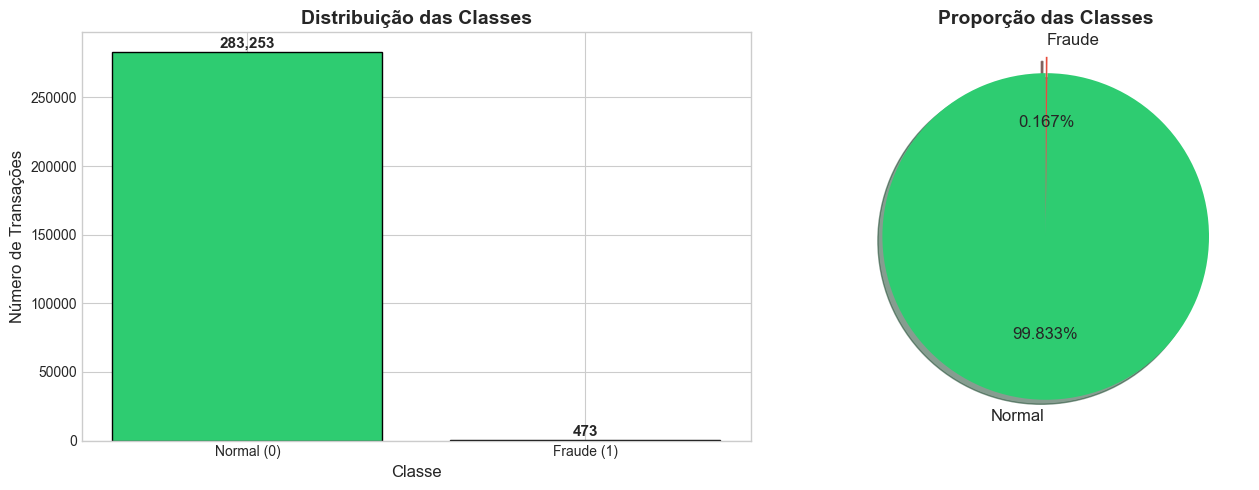

ANÁLISE DO DESBALANCEAMENTO

Transações Normais: 283,253 (99.833%)
Transações Fraudulentas: 473 (0.167%)
Razão de Desbalanceamento: 1:598


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Normal (0)', 'Fraude (1)'], class_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Número de Transações', fontsize=12)
axes[0].set_xlabel('Classe', fontsize=12)

for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

explode = (0, 0.1)
axes[1].pie(class_counts.values, explode=explode, labels=['Normal', 'Fraude'], 
            colors=colors, autopct='%1.3f%%', shadow=True, startangle=90,
            textprops={'fontsize': 12})
axes[1].set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("ANÁLISE DO DESBALANCEAMENTO")
fraud_count = df[df['Class'] == 1].shape[0]
normal_count = df[df['Class'] == 0].shape[0]
print(f"\nTransações Normais: {normal_count:,} ({normal_count/len(df)*100:.3f}%)")
print(f"Transações Fraudulentas: {fraud_count:,} ({fraud_count/len(df)*100:.3f}%)")
print(f"Razão de Desbalanceamento: 1:{normal_count//fraud_count}")

### 3.2 Análise das Features Time e Amount

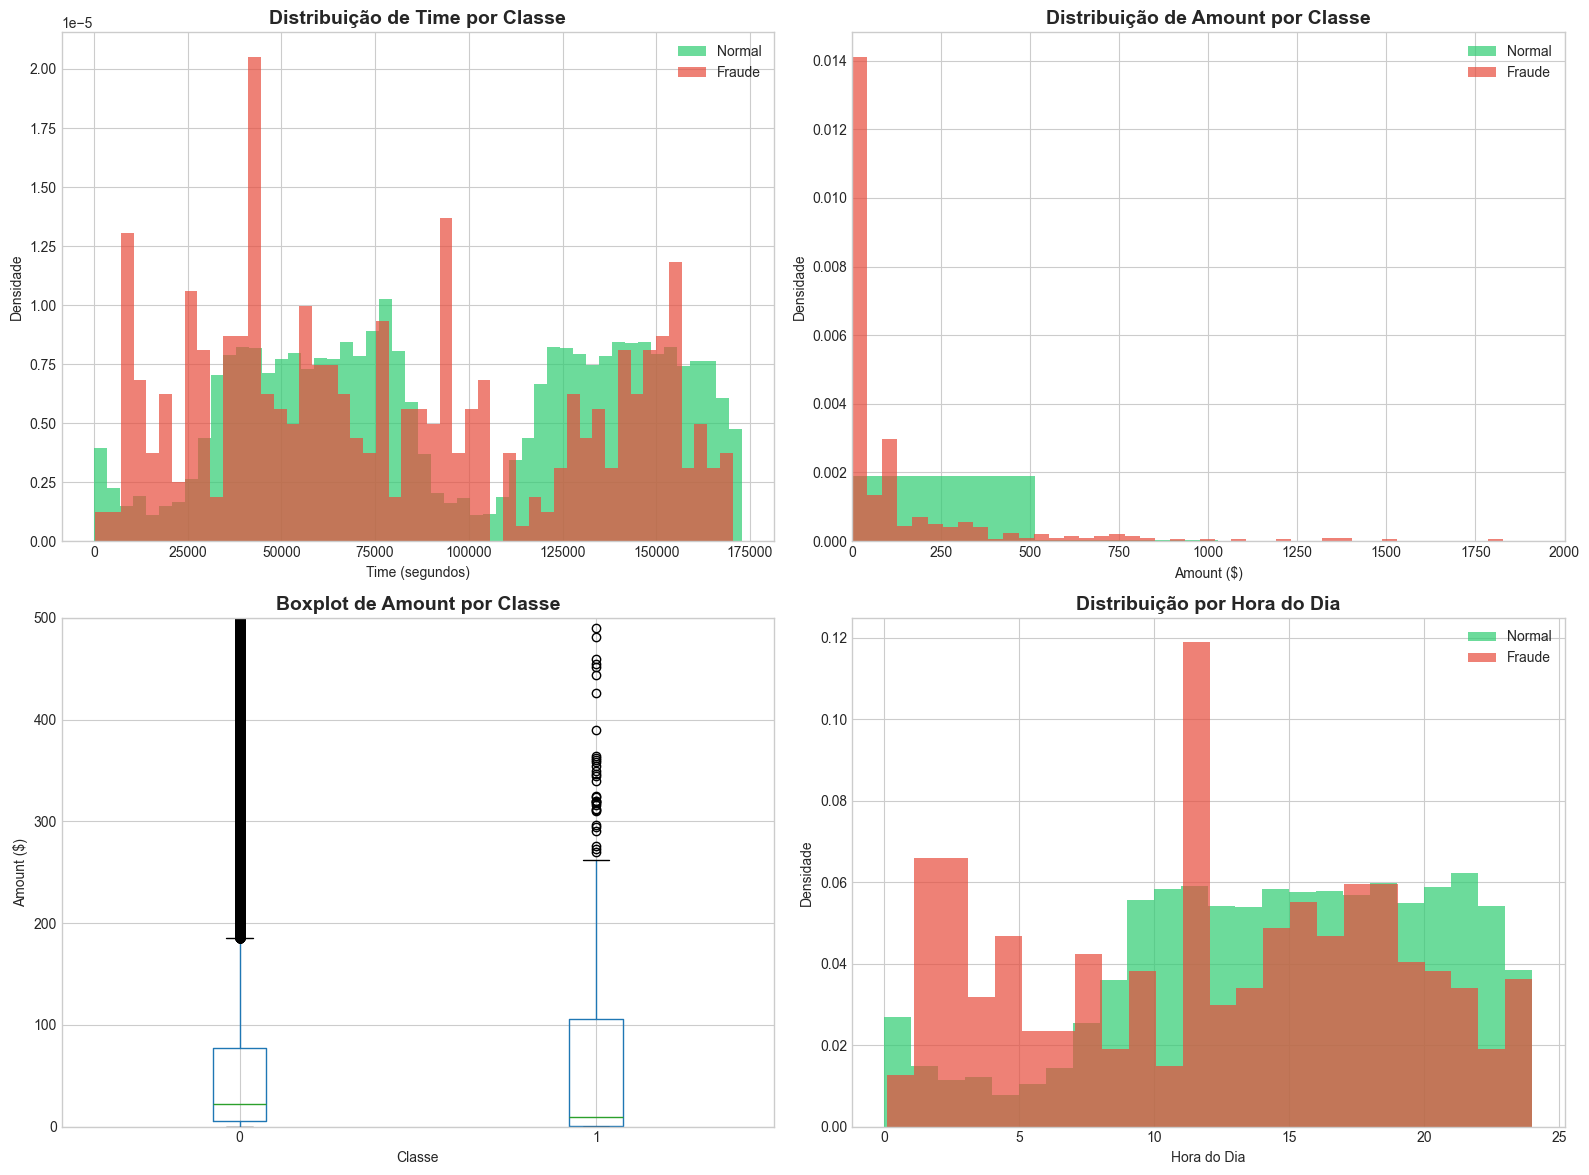

ESTATÍSTICAS DE TIME E AMOUNT

Amount - Transações Normais:
   Média: $88.41
   Mediana: $22.00
   Desvio Padrão: $250.38
   Máximo: $25691.16

Amount - Transações Fraudulentas:
   Média: $123.87
   Mediana: $9.82
   Desvio Padrão: $260.21
   Máximo: $2125.87


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

axes[0, 0].hist(normal_df['Time'], bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[0, 0].hist(fraud_df['Time'], bins=50, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[0, 0].set_title('Distribuição de Time por Classe', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time (segundos)')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].legend()

axes[0, 1].hist(normal_df['Amount'], bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[0, 1].hist(fraud_df['Amount'], bins=50, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[0, 1].set_title('Distribuição de Amount por Classe', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Amount ($)')
axes[0, 1].set_ylabel('Densidade')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 2000)  

df.boxplot(column='Amount', by='Class', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot de Amount por Classe', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Classe')
axes[1, 0].set_ylabel('Amount ($)')
axes[1, 0].set_ylim(0, 500)
plt.suptitle('')

df['Hour'] = (df['Time'] / 3600) % 24
fraud_hours = df[df['Class'] == 1]['Hour']
normal_hours = df[df['Class'] == 0]['Hour']

axes[1, 1].hist(normal_hours, bins=24, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[1, 1].hist(fraud_hours, bins=24, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[1, 1].set_title('Distribuição por Hora do Dia', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hora do Dia')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('time_amount_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("ESTATÍSTICAS DE TIME E AMOUNT")
print("\nAmount - Transações Normais:")
print(f"   Média: ${normal_df['Amount'].mean():.2f}")
print(f"   Mediana: ${normal_df['Amount'].median():.2f}")
print(f"   Desvio Padrão: ${normal_df['Amount'].std():.2f}")
print(f"   Máximo: ${normal_df['Amount'].max():.2f}")

print("\nAmount - Transações Fraudulentas:")
print(f"   Média: ${fraud_df['Amount'].mean():.2f}")
print(f"   Mediana: ${fraud_df['Amount'].median():.2f}")
print(f"   Desvio Padrão: ${fraud_df['Amount'].std():.2f}")
print(f"   Máximo: ${fraud_df['Amount'].max():.2f}")

### 3.3 Análise das Features PCA (V1-V28)

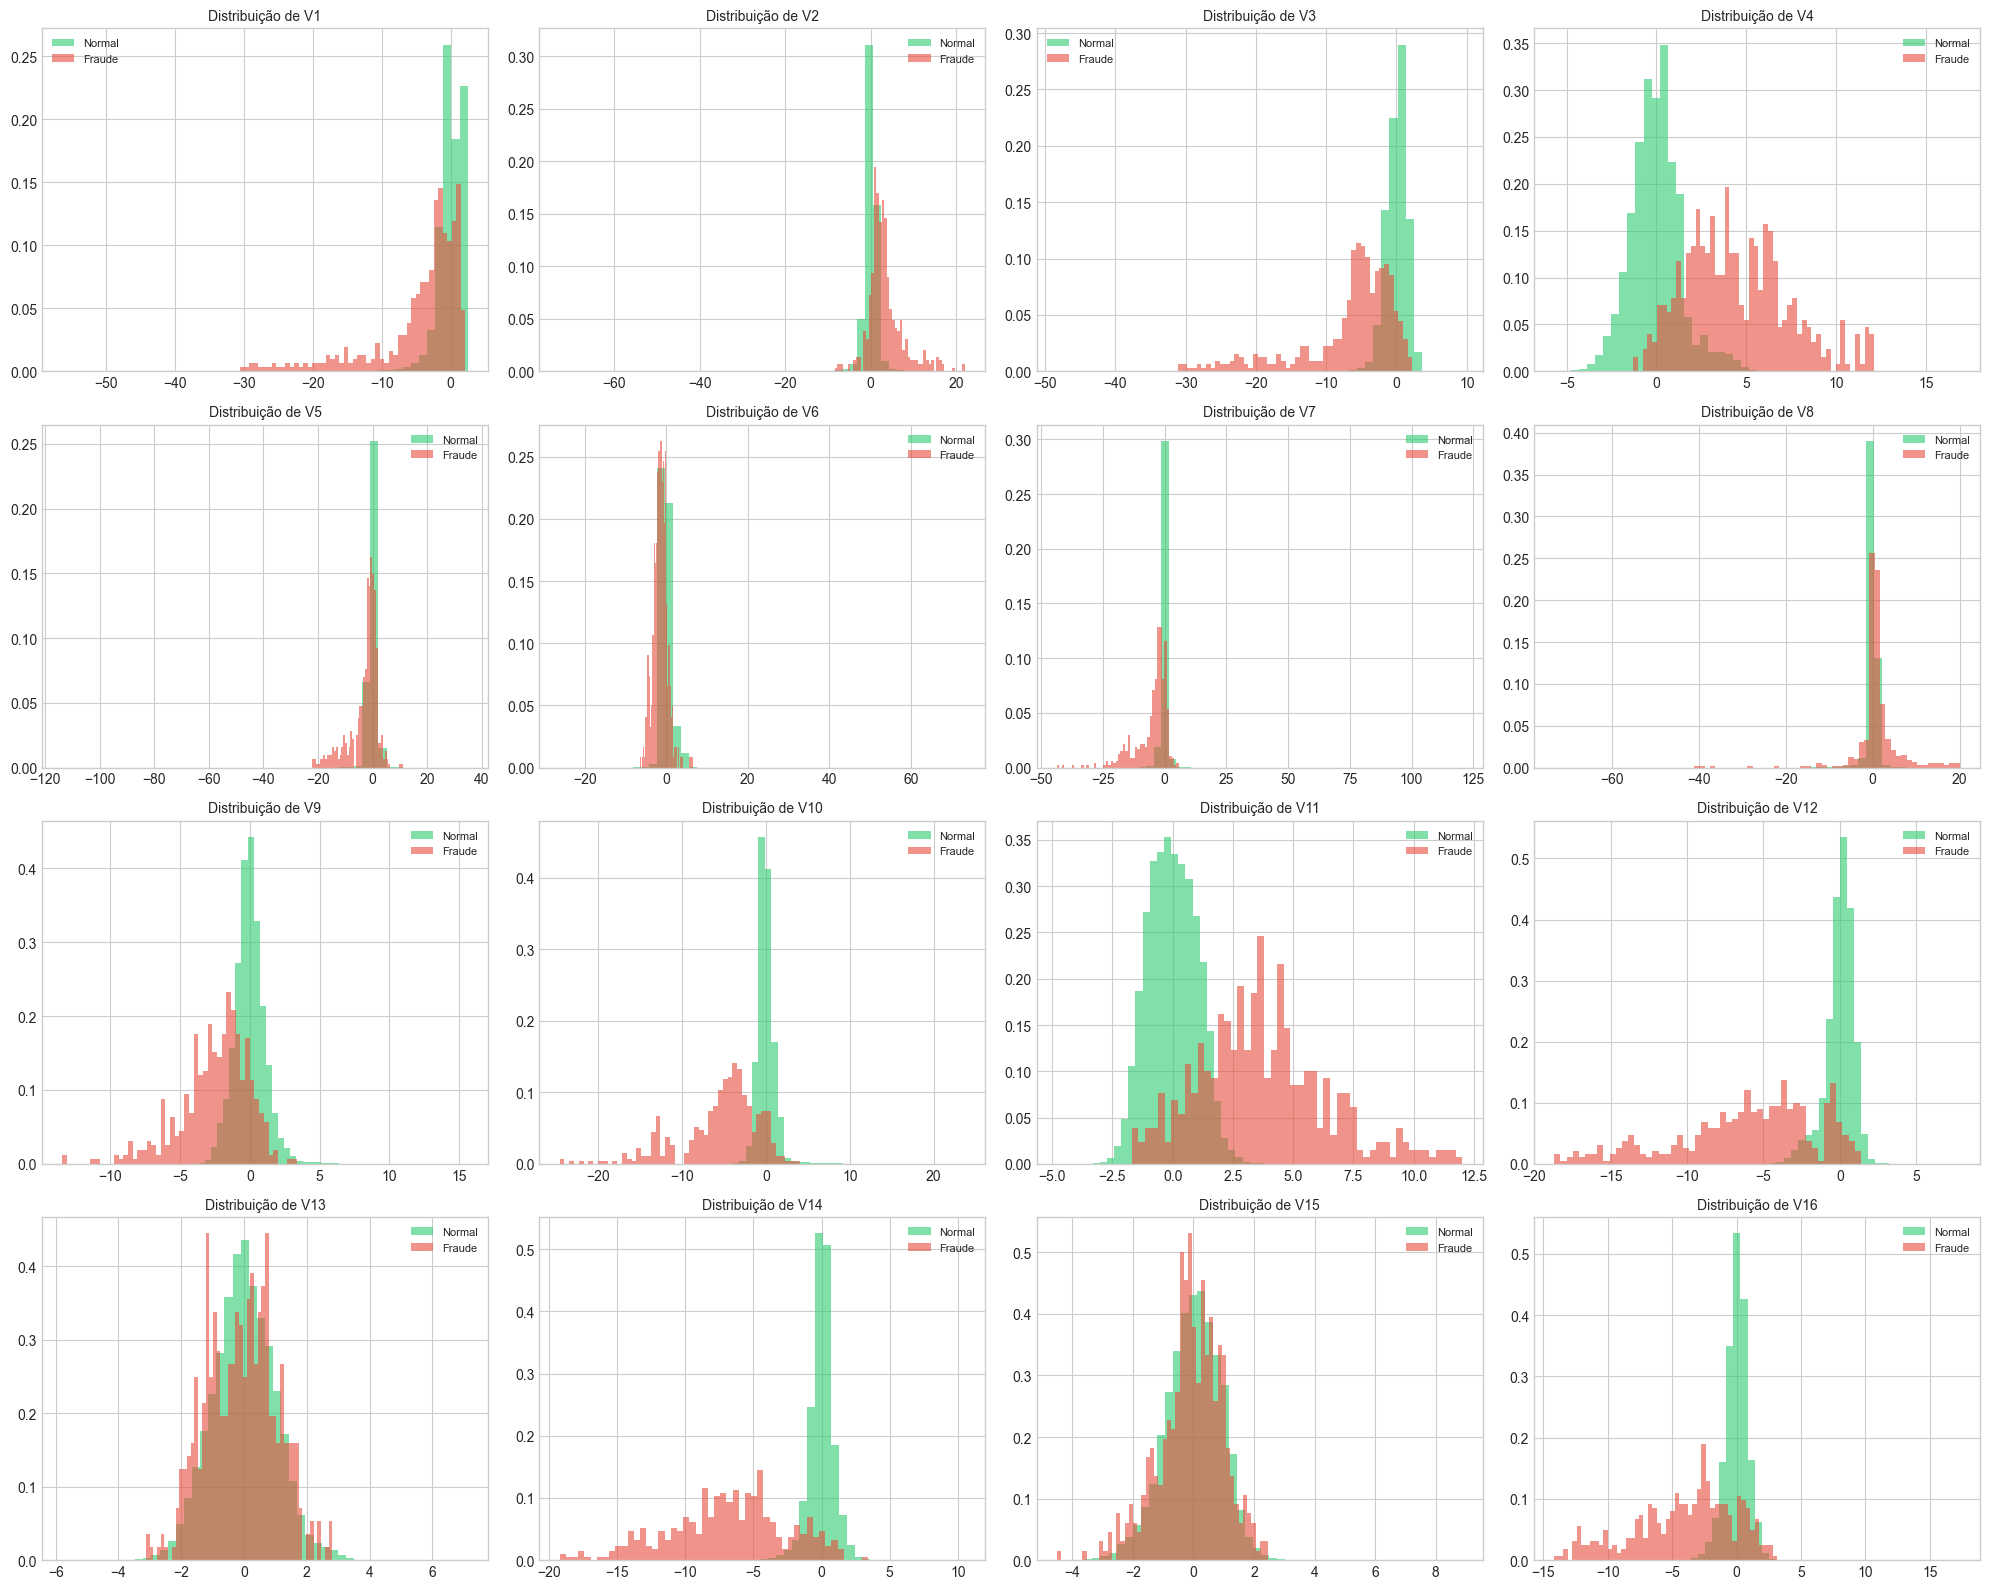

In [8]:
v_features = [f'V{i}' for i in range(1, 29)]

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, feature in enumerate(v_features[:16]):
    axes[i].hist(normal_df[feature], bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
    axes[i].hist(fraud_df[feature], bins=50, alpha=0.6, label='Fraude', color='#e74c3c', density=True)
    axes[i].set_title(f'Distribuição de {feature}', fontsize=10)
    axes[i].legend(fontsize=8)
    
plt.tight_layout()
plt.savefig('v_features_distribution_1.png', dpi=150, bbox_inches='tight')
plt.show()

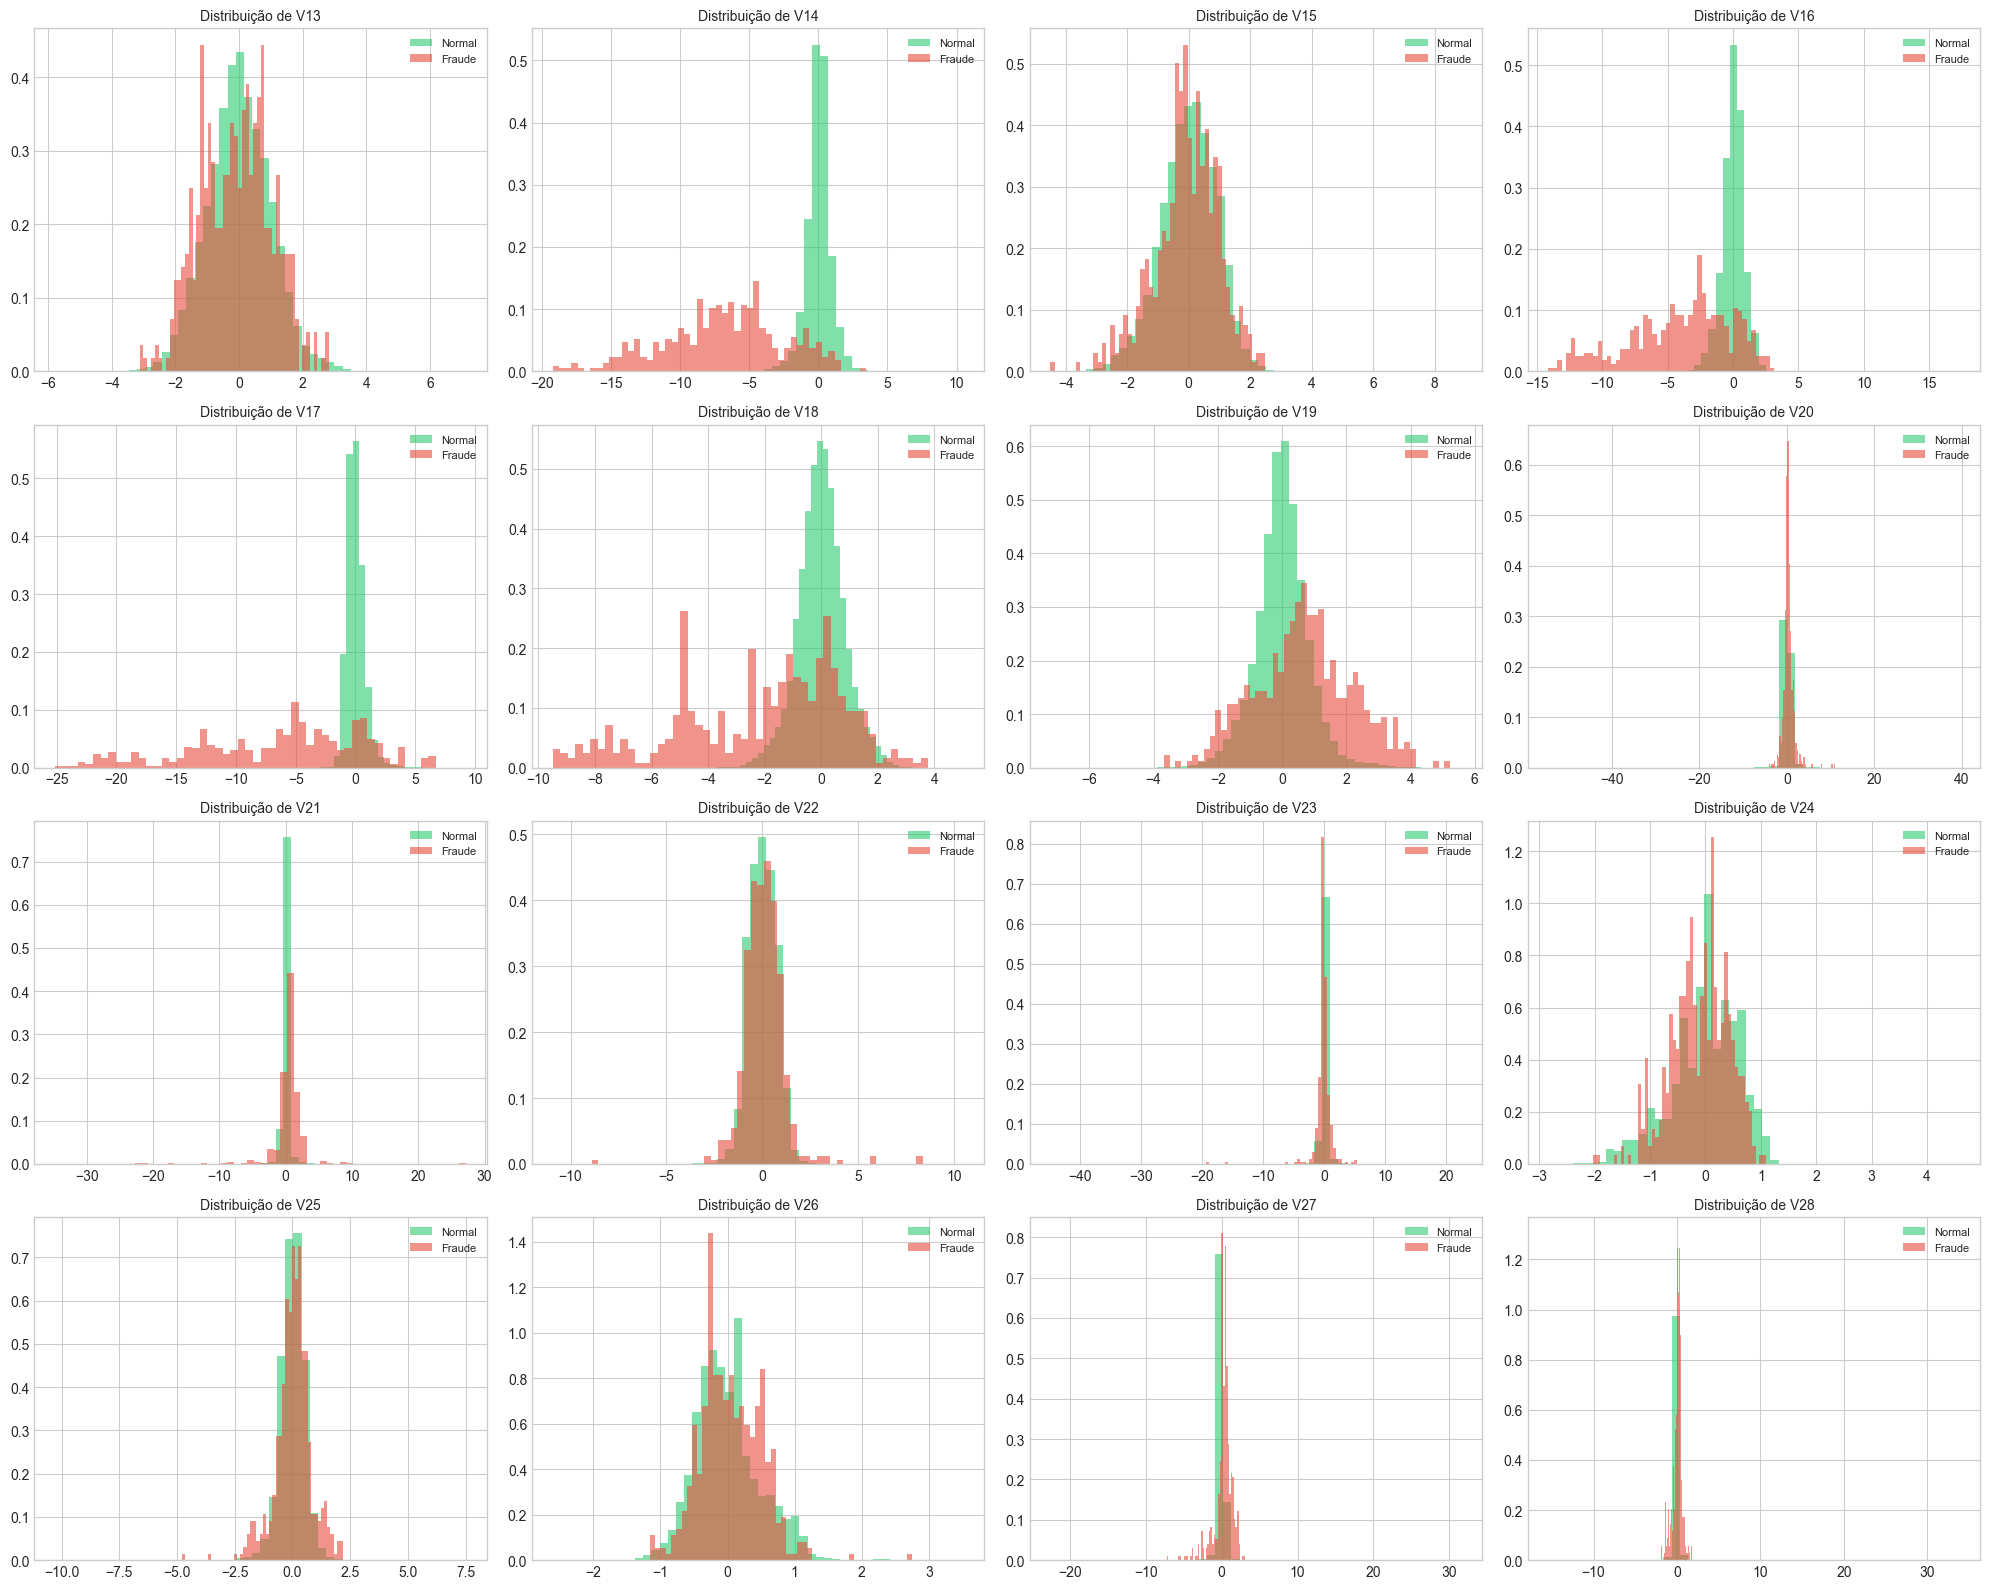

In [9]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, feature in enumerate(v_features[12:28]):
    axes[i].hist(normal_df[feature], bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
    axes[i].hist(fraud_df[feature], bins=50, alpha=0.6, label='Fraude', color='#e74c3c', density=True)
    axes[i].set_title(f'Distribuição de {feature}', fontsize=10)
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.savefig('v_features_distribution_2.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Matriz de Correlação

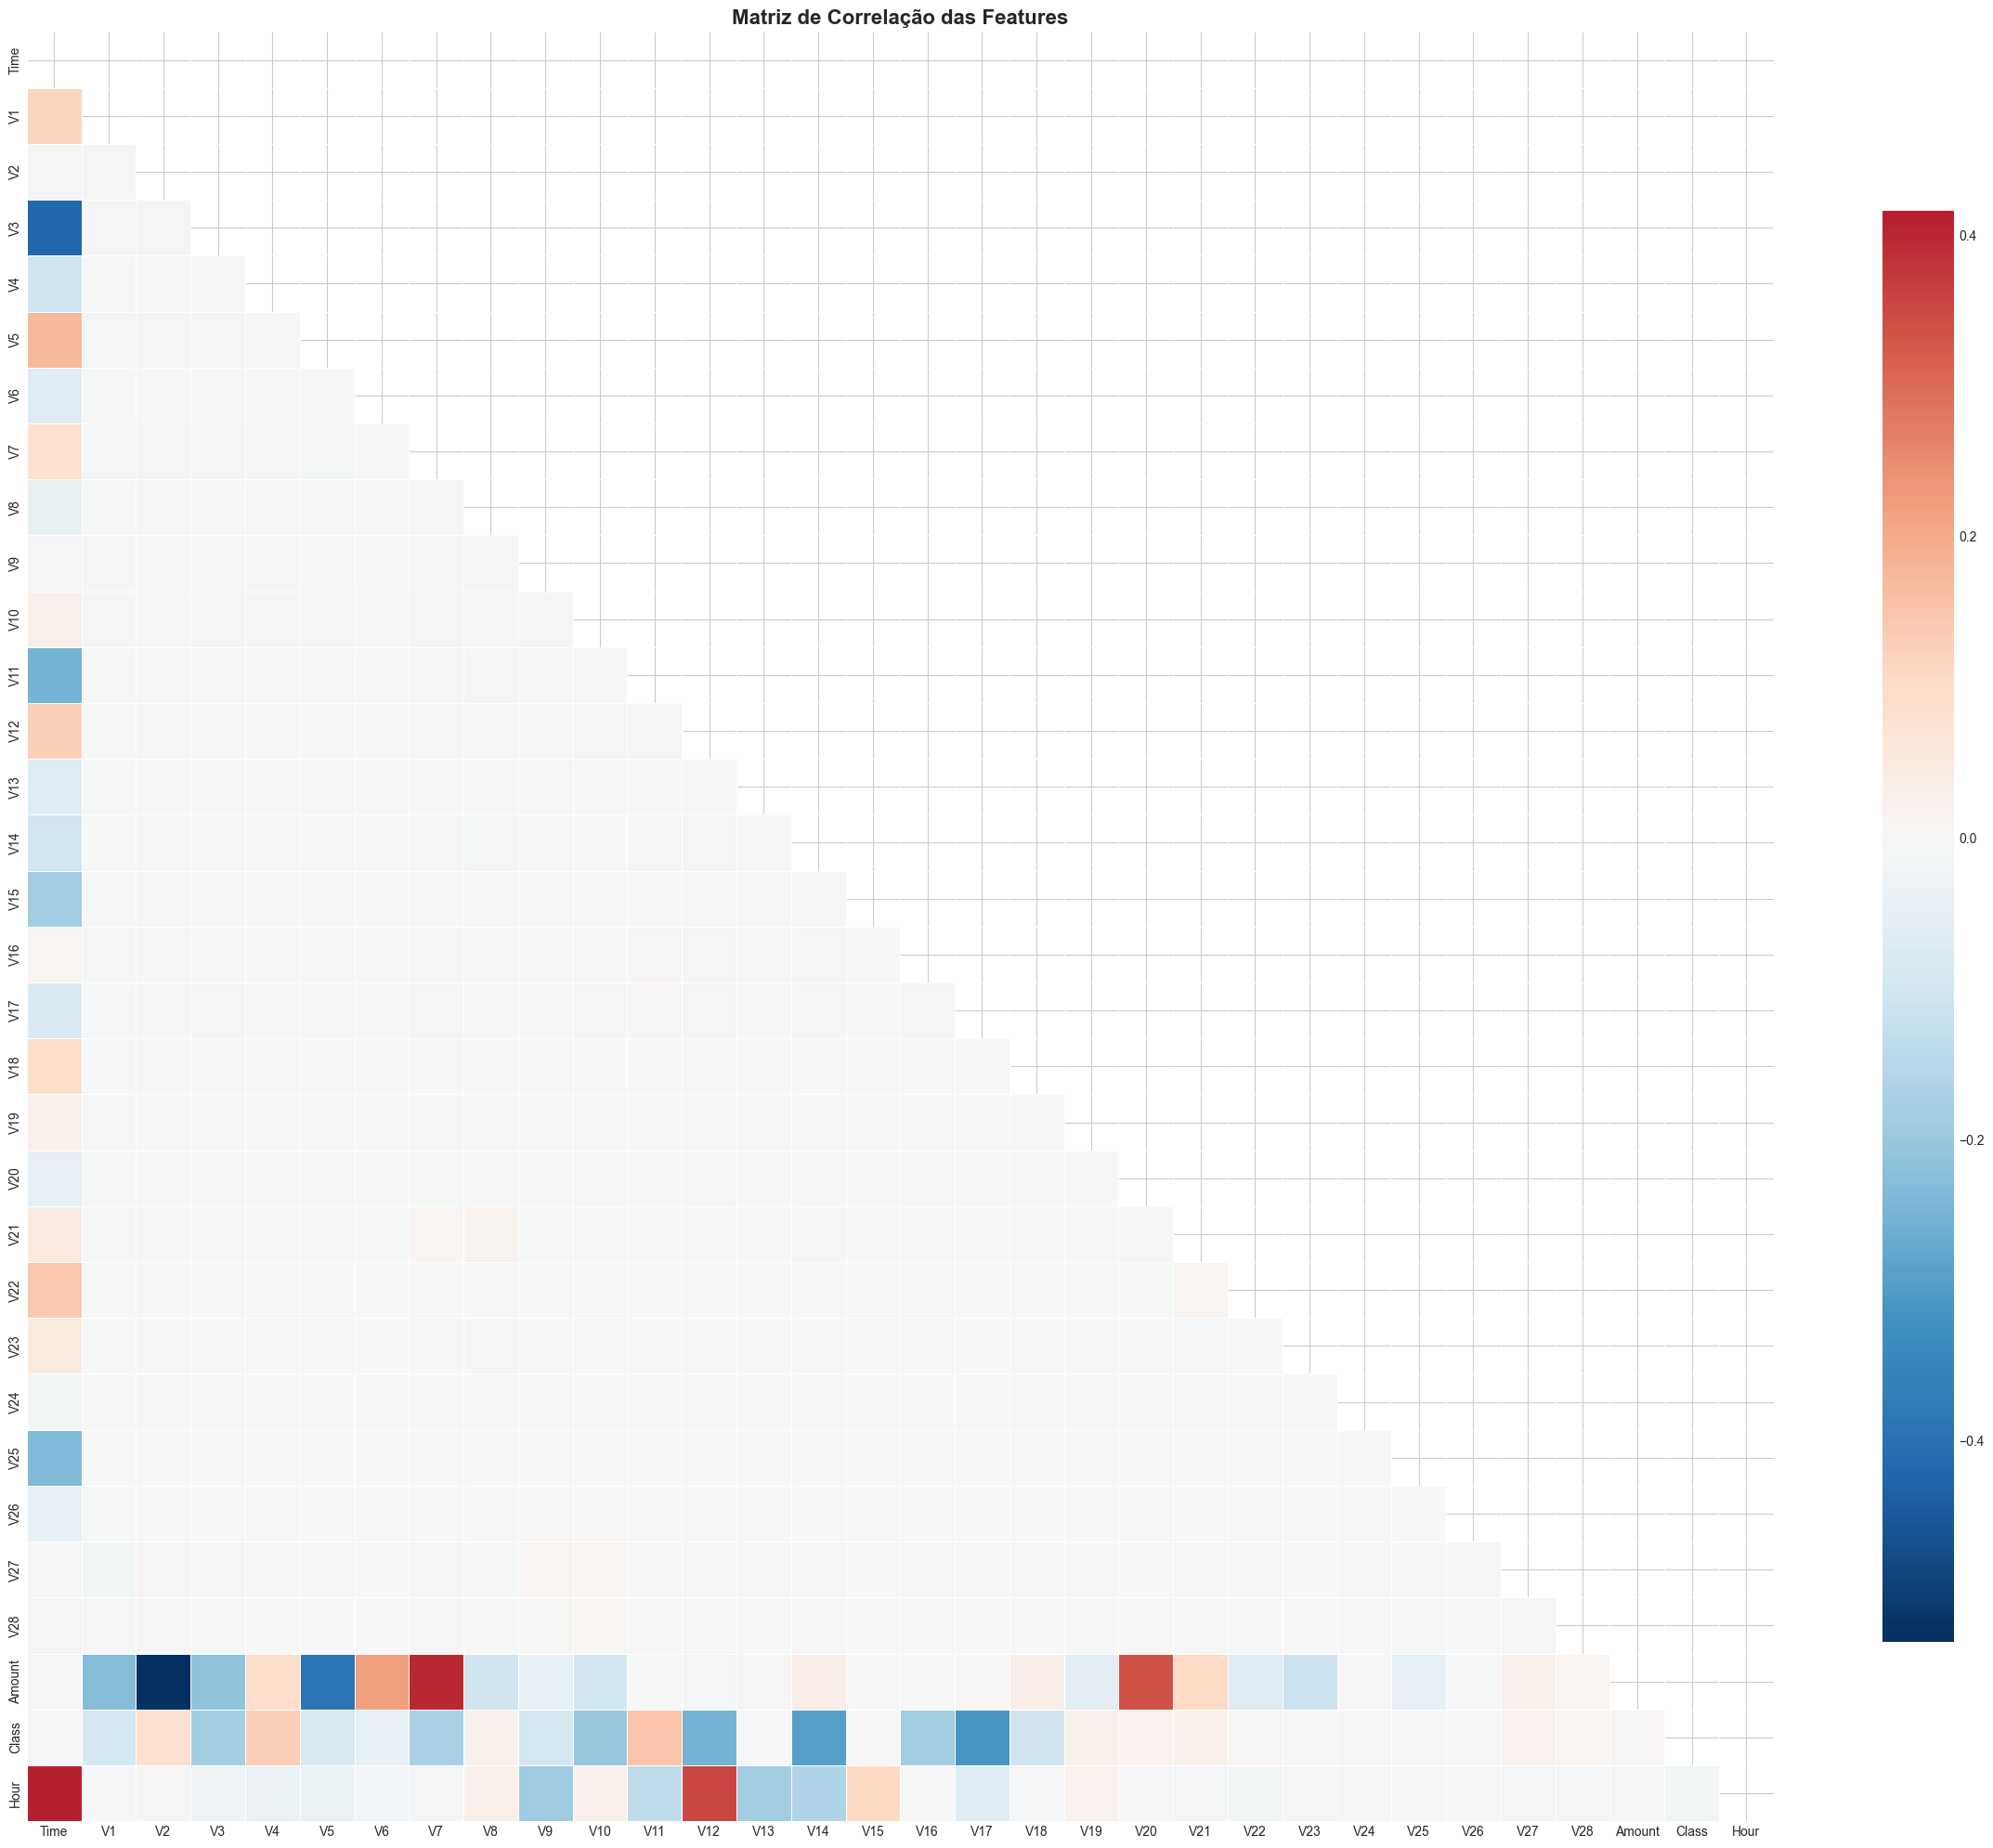

CORRELAÇÃO DAS FEATURES COM A CLASSE TARGET

Top 10 correlações mais fortes (em valor absoluto):
V17   -0.313498
V14   -0.293375
V12   -0.250711
V10   -0.206971
V16   -0.187186
V3    -0.182322
V7    -0.172347
V11    0.149067
V4     0.129326
V18   -0.105340
Name: Class, dtype: float64

Top 10 correlações mais fracas:
Time     -0.012359
V28       0.009682
V24      -0.007210
V23      -0.006333
Amount    0.005777
V22       0.004887
V26       0.004265
V13      -0.003897
V15      -0.003300
V25       0.003202
Name: Class, dtype: float64


In [6]:
plt.figure(figsize=(24, 20))
correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', 
            center=0, linewidths=0.5, fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação das Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("CORRELAÇÃO DAS FEATURES COM A CLASSE TARGET")
correlations_with_class = df.corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)
print("\nTop 10 correlações mais fortes (em valor absoluto):")
print(correlations_with_class.head(10))
print("\nTop 10 correlações mais fracas:")
print(correlations_with_class.tail(10))

## 4. Pré-processamento dos Dados

### 4.1 Normalização das Features

As features V1-V28 já estão normalizadas (resultado de PCA), mas **Time** e **Amount** precisam ser normalizadas.
Utilizaremos o **RobustScaler** para Amount (menos sensível a outliers) e **StandardScaler** para Time.

In [7]:
df_processed = df.copy()

if 'Hour' in df_processed.columns:
    df_processed = df_processed.drop('Hour', axis=1)

robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

df_processed['Amount_scaled'] = robust_scaler.fit_transform(df_processed['Amount'].values.reshape(-1, 1))

df_processed['Time_scaled'] = standard_scaler.fit_transform(df_processed['Time'].values.reshape(-1, 1))

df_processed = df_processed.drop(['Time', 'Amount'], axis=1)

print("Normalização concluída!")
print(f"\nShape do dataset processado: {df_processed.shape}")
print(f"\nColunas após pré-processamento:")
print(df_processed.columns.tolist())

Normalização concluída!

Shape do dataset processado: (283726, 31)

Colunas após pré-processamento:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Amount_scaled', 'Time_scaled']


### 4.2 Separação dos Dados em Treino, Validação e Teste

Utilizaremos a seguinte divisão:
- **Treino:** 70% dos dados
- **Validação:** 15% dos dados  
- **Teste:** 15% dos dados

**Importante:** Para detecção de anomalias em abordagem semi-supervisionada, treinaremos os modelos apenas com transações **normais**.

In [8]:
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("DIVISÃO DOS DADOS")

print(f"\nConjunto de TREINO:")
print(f"   Total: {len(X_train):,} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Normal: {(y_train == 0).sum():,}")
print(f"   Fraude: {(y_train == 1).sum():,}")

print(f"\nConjunto de VALIDAÇÃO:")
print(f"   Total: {len(X_val):,} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Normal: {(y_val == 0).sum():,}")
print(f"   Fraude: {(y_val == 1).sum():,}")

print(f"\nConjunto de TESTE:")
print(f"   Total: {len(X_test):,} amostras ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Normal: {(y_test == 0).sum():,}")
print(f"   Fraude: {(y_test == 1).sum():,}")

DIVISÃO DOS DADOS

Conjunto de TREINO:
   Total: 198,608 amostras (70.0%)
   Normal: 198,277
   Fraude: 331

Conjunto de VALIDAÇÃO:
   Total: 42,559 amostras (15.0%)
   Normal: 42,488
   Fraude: 71

Conjunto de TESTE:
   Total: 42,559 amostras (15.0%)
   Normal: 42,488
   Fraude: 71


In [9]:

X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]


print("CONJUNTO DE TREINO PARA ABORDAGEM SEMI-SUPERVISIONADA")

print(f"\n📊 Treino apenas com transações NORMAIS:")
print(f"   Total: {len(X_train_normal):,} amostras")
print(f"   (Usaremos este conjunto para treinar os modelos de anomalia)")

CONJUNTO DE TREINO PARA ABORDAGEM SEMI-SUPERVISIONADA

📊 Treino apenas com transações NORMAIS:
   Total: 198,277 amostras
   (Usaremos este conjunto para treinar os modelos de anomalia)


## 5. Feature Engineering e Seleção de Features

### 5.1 Análise de Importância das Features

As features V1-V28 já são resultado de PCA, aplicado para manter a confidencialidade dos dados originais. Vamos analisar quais features apresentam maior diferença entre classes para auxiliar na interpretação.

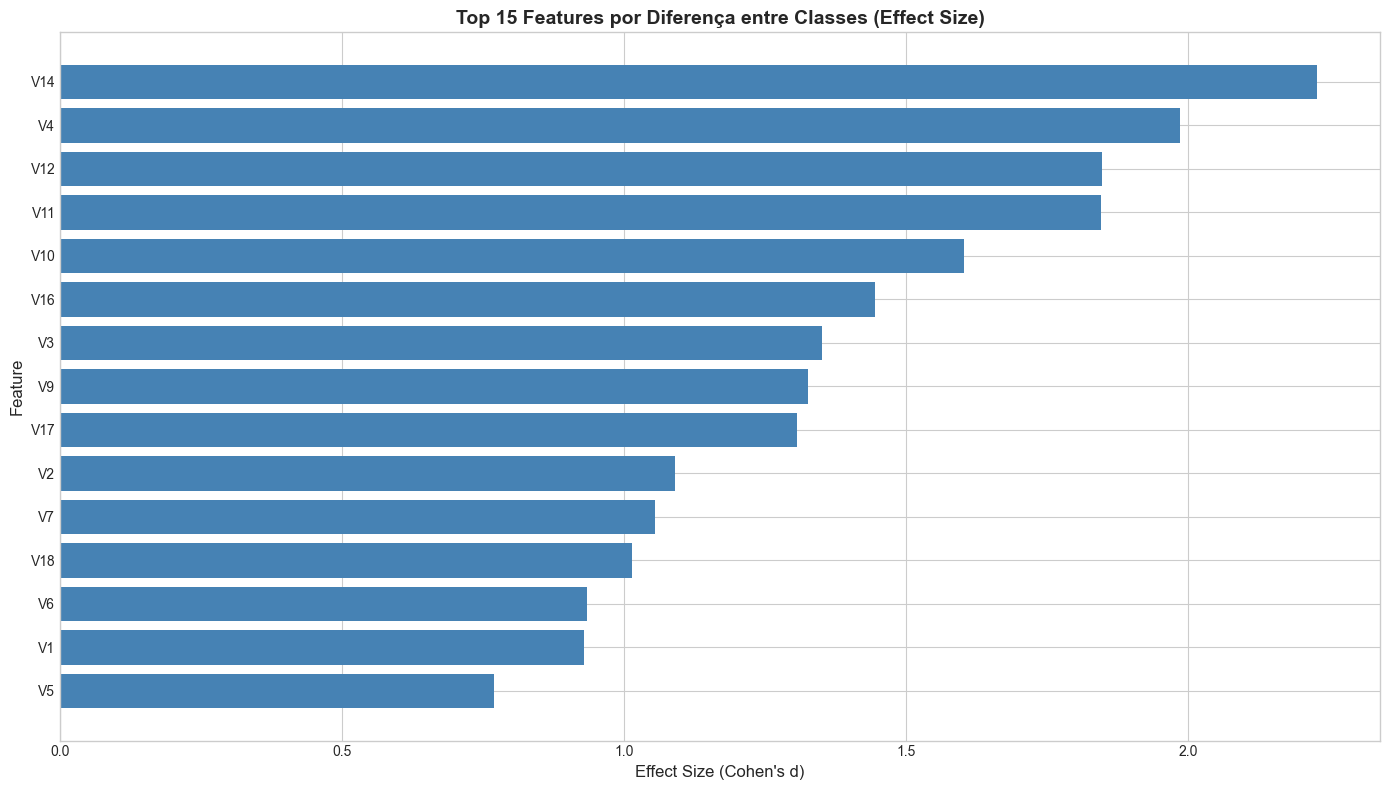


Top 10 Features com maior diferença entre classes:
Feature  Effect_Size
    V14     2.228136
     V4     1.984959
    V12     1.847619
    V11     1.844141
    V10     1.602536
    V16     1.444884
     V3     1.350277
     V9     1.325343
    V17     1.306905
     V2     1.089375


In [10]:
feature_importance = []
features = X.columns.tolist()

for feature in features:
    fraud_mean = df_processed[df_processed['Class'] == 1][feature].mean()
    normal_mean = df_processed[df_processed['Class'] == 0][feature].mean()
    fraud_std = df_processed[df_processed['Class'] == 1][feature].std()
    normal_std = df_processed[df_processed['Class'] == 0][feature].std()
    

    pooled_std = np.sqrt((fraud_std**2 + normal_std**2) / 2)
    if pooled_std > 0:
        effect_size = abs(fraud_mean - normal_mean) / pooled_std
    else:
        effect_size = 0
    
    feature_importance.append({
        'Feature': feature,
        'Fraud_Mean': fraud_mean,
        'Normal_Mean': normal_mean,
        'Effect_Size': effect_size
    })

importance_df = pd.DataFrame(feature_importance)
importance_df = importance_df.sort_values('Effect_Size', ascending=False)

plt.figure(figsize=(14, 8))
top_features = importance_df.head(15)
bars = plt.barh(top_features['Feature'], top_features['Effect_Size'], color='steelblue')
plt.xlabel('Effect Size (Cohen\'s d)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Features por Diferença entre Classes (Effect Size)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Features com maior diferença entre classes:")
print(importance_df[['Feature', 'Effect_Size']].head(10).to_string(index=False))

### 5.2 Seleção de Features

Para este projeto, utilizaremos **todas as features** disponíveis, pois:
1. As features V1-V28 já são componentes principais otimizados
2. Mesmo features com baixa correlação individual podem contribuir em combinação
3. Os algoritmos de detecção de anomalias são capazes de lidar com múltiplas dimensões

Caso seja necessário reduzir dimensionalidade, as features com maior effect size seriam priorizadas.

In [15]:
print("FEATURES SELECIONADAS PARA MODELAGEM")

print(f"\nTotal de features: {X.shape[1]}")
print(f"\nLista de features:")
for i, col in enumerate(X.columns, 1):
    print(f"   {i:2d}. {col}")

FEATURES SELECIONADAS PARA MODELAGEM

Total de features: 30

Lista de features:
    1. V1
    2. V2
    3. V3
    4. V4
    5. V5
    6. V6
    7. V7
    8. V8
    9. V9
   10. V10
   11. V11
   12. V12
   13. V13
   14. V14
   15. V15
   16. V16
   17. V17
   18. V18
   19. V19
   20. V20
   21. V21
   22. V22
   23. V23
   24. V24
   25. V25
   26. V26
   27. V27
   28. V28
   29. Amount_scaled
   30. Time_scaled


## 6. Modelagem

### 6.1 Funções Auxiliares para Avaliação

In [11]:
def evaluate_model(y_true, y_pred, y_scores=None, model_name="Model"):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
    }
    
    if y_scores is not None:
        metrics['AUC-ROC'] = roc_auc_score(y_true, y_scores)
        metrics['AUC-PR'] = average_precision_score(y_true, y_scores)
    
    return metrics


def plot_confusion_matrix(y_true, y_pred, model_name="Model", ax=None):
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Fraude'],
                yticklabels=['Normal', 'Fraude'])
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    ax.set_title(f'Matriz de Confusão - {model_name}')
    
    return cm


def print_metrics(metrics):
    print(f"MÉTRICAS - {metrics['Model']}")
    print(f"  Acurácia:  {metrics['Accuracy']:.4f}")
    print(f"  Precisão:  {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")
    if 'AUC-ROC' in metrics:
        print(f"  AUC-ROC:   {metrics['AUC-ROC']:.4f}")
    if 'AUC-PR' in metrics:
        print(f"  AUC-PR:    {metrics['AUC-PR']:.4f}")

all_results = {}
all_predictions = {}
all_scores = {}
all_times = {}

### 6.2 Modelo 1: Isolation Forest (Modelo Probabilístico)

**Por que Isolation Forest?**
- Baseado no princípio de que anomalias são "isoladas" mais facilmente
- Não assume uma distribuição específica dos dados
- Eficiente computacionalmente (O(n log n))
- Funciona bem com dados de alta dimensionalidade
- Ideal para detecção de outliers em datasets desbalanceados

**Funcionamento:**
1. Constrói árvores de decisão aleatórias
2. Anomalias requerem menos "cortes" para serem isoladas
3. O score de anomalia é baseado no caminho médio até o isolamento

Taxa de contaminação esperada: 0.0017 (0.17%)

TREINAMENTO - ISOLATION FOREST
Modelo treinado em 0.84 segundos
Tempo de inferência (validação): 0.24 segundos
MÉTRICAS - Isolation Forest
  Acurácia:  0.9970
  Precisão:  0.1705
  Recall:    0.2113
  F1-Score:  0.1887
  AUC-ROC:   0.9370
  AUC-PR:    0.1000


<Figure size 800x600 with 0 Axes>

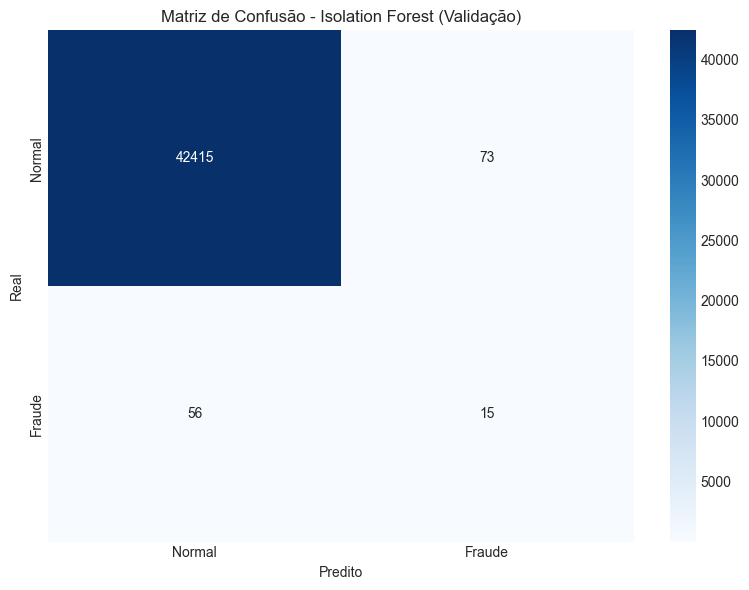

In [12]:
contamination_rate = y_val.mean()
print(f"Taxa de contaminação esperada: {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")

print("\n" + "=" * 60)
print("TREINAMENTO - ISOLATION FOREST")
print("=" * 60)

if_params = {
    'n_estimators': 100,
    'contamination': contamination_rate,
    'max_samples': 'auto',
    'random_state': 42,
    'n_jobs': -1
}

start_time = time.time()
iso_forest = IsolationForest(**if_params)
iso_forest.fit(X_train_normal) 
train_time_if = time.time() - start_time

print(f"Modelo treinado em {train_time_if:.2f} segundos")

start_time = time.time()
if_val_pred_raw = iso_forest.predict(X_val)
if_val_pred = np.where(if_val_pred_raw == -1, 1, 0)  
if_val_scores = -iso_forest.score_samples(X_val) 
inference_time_if_val = time.time() - start_time

print(f"Tempo de inferência (validação): {inference_time_if_val:.2f} segundos")

if_val_metrics = evaluate_model(y_val, if_val_pred, if_val_scores, "Isolation Forest")
print_metrics(if_val_metrics)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_val, if_val_pred, "Isolation Forest (Validação)")
plt.tight_layout()
plt.savefig('confusion_matrix_if_val.png', dpi=150, bbox_inches='tight')
plt.show()

#### 6.2.1 Tunagem de Hiperparâmetros - Isolation Forest

In [13]:
print("TUNAGEM DE HIPERPARÂMETROS - ISOLATION FOREST")

n_estimators_list = [50, 100, 200]
max_samples_list = [256, 512, 'auto']
contamination_list = [0.001, 0.002, 0.005, contamination_rate]

best_if_score = 0
best_if_params = {}
if_tuning_results = []

for n_est in n_estimators_list:
    for max_samp in max_samples_list:
        for contam in contamination_list:
            try:
                model = IsolationForest(
                    n_estimators=n_est,
                    max_samples=max_samp,
                    contamination=contam,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train_normal)
                
                pred_raw = model.predict(X_val)
                pred = np.where(pred_raw == -1, 1, 0)
                scores = -model.score_samples(X_val)
                
                f1 = f1_score(y_val, pred, zero_division=0)
                auc = roc_auc_score(y_val, scores)
                
                if_tuning_results.append({
                    'n_estimators': n_est,
                    'max_samples': max_samp,
                    'contamination': contam,
                    'F1-Score': f1,
                    'AUC-ROC': auc
                })
                
                if f1 > best_if_score:
                    best_if_score = f1
                    best_if_params = {
                        'n_estimators': n_est,
                        'max_samples': max_samp,
                        'contamination': contam
                    }
            except Exception as e:
                print(f"Erro com params {n_est}, {max_samp}, {contam}: {e}")

if_tuning_df = pd.DataFrame(if_tuning_results).sort_values('F1-Score', ascending=False)
print("\nTop 10 combinações de hiperparâmetros:")
print(if_tuning_df.head(10).to_string(index=False))

print(f"\nMelhores hiperparâmetros encontrados:")
print(f"   n_estimators: {best_if_params['n_estimators']}")
print(f"   max_samples: {best_if_params['max_samples']}")
print(f"   contamination: {best_if_params['contamination']}")
print(f"   F1-Score: {best_if_score:.4f}")

TUNAGEM DE HIPERPARÂMETROS - ISOLATION FOREST

Top 10 combinações de hiperparâmetros:
 n_estimators max_samples  contamination  F1-Score  AUC-ROC
           50         512       0.002000  0.208589 0.935641
           50         512       0.001668  0.202703 0.935641
          100         512       0.001668  0.200000 0.936742
           50         512       0.001000  0.196721 0.935641
           50         256       0.001000  0.193548 0.931693
           50        auto       0.001000  0.193548 0.931693
          100         256       0.001000  0.192000 0.937019
          100        auto       0.001000  0.192000 0.937019
          200         256       0.001668  0.191083 0.934985
          200        auto       0.001668  0.191083 0.934985

Melhores hiperparâmetros encontrados:
   n_estimators: 50
   max_samples: 512
   contamination: 0.002
   F1-Score: 0.2086


In [14]:
print("MODELO FINAL - ISOLATION FOREST")

iso_forest_best = IsolationForest(
    n_estimators=best_if_params['n_estimators'],
    max_samples=best_if_params['max_samples'],
    contamination=best_if_params['contamination'],
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
iso_forest_best.fit(X_train_normal)
train_time_if_best = time.time() - start_time

start_time = time.time()
if_test_pred_raw = iso_forest_best.predict(X_test)
if_test_pred = np.where(if_test_pred_raw == -1, 1, 0)
if_test_scores = -iso_forest_best.score_samples(X_test)
inference_time_if = time.time() - start_time

if_test_metrics = evaluate_model(y_test, if_test_pred, if_test_scores, "Isolation Forest (Best)")
print_metrics(if_test_metrics)
print(f"\nTempo de treino: {train_time_if_best:.2f}s")
print(f"Tempo de inferência (teste): {inference_time_if:.4f}s")
print(f"Tempo médio por amostra: {inference_time_if/len(X_test)*1000:.4f}ms")

all_results['Isolation Forest'] = if_test_metrics
all_predictions['Isolation Forest'] = if_test_pred
all_scores['Isolation Forest'] = if_test_scores
all_times['Isolation Forest'] = {
    'train': train_time_if_best,
    'inference': inference_time_if,
    'per_sample': inference_time_if/len(X_test)*1000
}

MODELO FINAL - ISOLATION FOREST
MÉTRICAS - Isolation Forest (Best)
  Acurácia:  0.9965
  Precisão:  0.1985
  Recall:    0.3662
  F1-Score:  0.2574
  AUC-ROC:   0.9531
  AUC-PR:    0.1127

Tempo de treino: 0.51s
Tempo de inferência (teste): 0.1396s
Tempo médio por amostra: 0.0033ms


### 6.3 Modelo 2: Local Outlier Factor - LOF (Modelo Baseado em Densidade)

**Por que LOF?**
- Algoritmo baseado em densidade local
- Detecta anomalias considerando a densidade dos vizinhos
- Captura anomalias locais que podem ser diferentes em diferentes regiões do espaço
- Não assume forma específica dos clusters

**Funcionamento:**
1. Calcula a densidade local de cada ponto baseado em k vizinhos
2. Compara a densidade de um ponto com a de seus vizinhos
3. Pontos com densidade significativamente menor são anomalias
4. LOF > 1 indica potencial anomalia

Modelo treinado em 20.04 segundos
Tempo de inferência (validação): 8.80 segundos
MÉTRICAS - LOF
  Acurácia:  0.9965
  Precisão:  0.0000
  Recall:    0.0000
  F1-Score:  0.0000
  AUC-ROC:   0.7874
  AUC-PR:    0.0097


<Figure size 800x600 with 0 Axes>

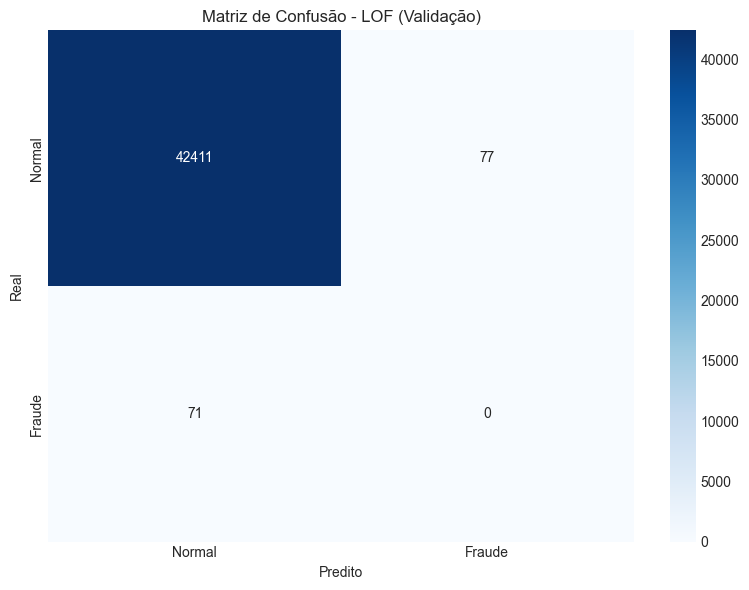

In [15]:

lof_params = {
    'n_neighbors': 20,
    'contamination': contamination_rate,
    'novelty': True,
    'n_jobs': -1
}

start_time = time.time()
lof = LocalOutlierFactor(**lof_params)
lof.fit(X_train_normal)
train_time_lof = time.time() - start_time

print(f"Modelo treinado em {train_time_lof:.2f} segundos")

start_time = time.time()
lof_val_pred_raw = lof.predict(X_val)
lof_val_pred = np.where(lof_val_pred_raw == -1, 1, 0)
lof_val_scores = -lof.score_samples(X_val)
inference_time_lof_val = time.time() - start_time

print(f"Tempo de inferência (validação): {inference_time_lof_val:.2f} segundos")

lof_val_metrics = evaluate_model(y_val, lof_val_pred, lof_val_scores, "LOF")
print_metrics(lof_val_metrics)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_val, lof_val_pred, "LOF (Validação)")
plt.tight_layout()
plt.savefig('confusion_matrix_lof_val.png', dpi=150, bbox_inches='tight')
plt.show()

#### 6.3.1 Tunagem de Hiperparâmetros - LOF

In [16]:

n_neighbors_list = [5, 10, 20, 30, 50]
contamination_list_lof = [0.001, 0.002, 0.005, contamination_rate]

best_lof_score = 0
best_lof_params = {}
lof_tuning_results = []

for n_neigh in n_neighbors_list:
    for contam in contamination_list_lof:
        try:
            model = LocalOutlierFactor(
                n_neighbors=n_neigh,
                contamination=contam,
                novelty=True,
                n_jobs=-1
            )
            model.fit(X_train_normal)
            
            pred_raw = model.predict(X_val)
            pred = np.where(pred_raw == -1, 1, 0)
            scores = -model.score_samples(X_val)
            
            f1 = f1_score(y_val, pred, zero_division=0)
            auc = roc_auc_score(y_val, scores)
            
            lof_tuning_results.append({
                'n_neighbors': n_neigh,
                'contamination': contam,
                'F1-Score': f1,
                'AUC-ROC': auc
            })
            
            if f1 > best_lof_score:
                best_lof_score = f1
                best_lof_params = {
                    'n_neighbors': n_neigh,
                    'contamination': contam
                }
        except Exception as e:
            print(f"Erro com params {n_neigh}, {contam}: {e}")

lof_tuning_df = pd.DataFrame(lof_tuning_results).sort_values('F1-Score', ascending=False)
print("\nTop 10 combinações de hiperparâmetros:")
print(lof_tuning_df.head(10).to_string(index=False))

print(f"\nMelhores hiperparâmetros encontrados:")
print(f"   n_neighbors: {best_lof_params['n_neighbors']}")
print(f"   contamination: {best_lof_params['contamination']}")
print(f"   F1-Score: {best_lof_score:.4f}")


Top 10 combinações de hiperparâmetros:
 n_neighbors  contamination  F1-Score  AUC-ROC
          50       0.005000  0.206897 0.934037
          50       0.002000  0.132597 0.934037
          50       0.001668  0.089172 0.934037
          50       0.001000  0.065041 0.934037
           5       0.005000  0.055556 0.758343
          30       0.005000  0.032787 0.885836
          10       0.005000  0.031646 0.651034
          10       0.002000  0.023121 0.651034
          30       0.002000  0.022099 0.885836
          20       0.005000  0.013937 0.787402

Melhores hiperparâmetros encontrados:
   n_neighbors: 50
   contamination: 0.005
   F1-Score: 0.2069


In [17]:

print("MODELO FINAL - LOF")

lof_best = LocalOutlierFactor(
    n_neighbors=best_lof_params['n_neighbors'],
    contamination=best_lof_params['contamination'],
    novelty=True,
    n_jobs=-1
)

start_time = time.time()
lof_best.fit(X_train_normal)
train_time_lof_best = time.time() - start_time

start_time = time.time()
lof_test_pred_raw = lof_best.predict(X_test)
lof_test_pred = np.where(lof_test_pred_raw == -1, 1, 0)
lof_test_scores = -lof_best.score_samples(X_test)
inference_time_lof = time.time() - start_time

lof_test_metrics = evaluate_model(y_test, lof_test_pred, lof_test_scores, "LOF (Best)")
print_metrics(lof_test_metrics)
print(f"\nTempo de treino: {train_time_lof_best:.2f}s")
print(f"Tempo de inferência (teste): {inference_time_lof:.4f}s")
print(f"Tempo médio por amostra: {inference_time_lof/len(X_test)*1000:.4f}ms")

all_results['LOF'] = lof_test_metrics
all_predictions['LOF'] = lof_test_pred
all_scores['LOF'] = lof_test_scores
all_times['LOF'] = {
    'train': train_time_lof_best,
    'inference': inference_time_lof,
    'per_sample': inference_time_lof/len(X_test)*1000
}

MODELO FINAL - LOF
MÉTRICAS - LOF (Best)
  Acurácia:  0.9948
  Precisão:  0.1469
  Recall:    0.4366
  F1-Score:  0.2199
  AUC-ROC:   0.9362
  AUC-PR:    0.0970

Tempo de treino: 30.88s
Tempo de inferência (teste): 14.0619s
Tempo médio por amostra: 0.3304ms


### 6.4 Modelo 3: Autoencoder (Deep Learning)

**Por que Autoencoder?**
- Rede neural que aprende a reconstruir os dados de entrada
- Treinado apenas com dados normais, aprende a "representação" de normalidade
- Anomalias têm alto erro de reconstrução (não se encaixam no padrão aprendido)
- Capaz de capturar relações não-lineares complexas entre features

**Arquitetura:**
- **Encoder:** Comprime os dados para uma representação latente
- **Decoder:** Reconstrói os dados a partir da representação latente
- **Detecção:** Baseada no erro de reconstrução (MSE)

**Treinamento:**
- Treinar apenas com transações normais
- Validar com dados que incluem fraudes
- Threshold definido baseado no percentil do erro de reconstrução

In [23]:
def build_autoencoder(input_dim, encoding_dim=14, hidden_layers=[28, 21]):

    input_layer = Input(shape=(input_dim,))
    
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
    
    latent = Dense(encoding_dim, activation='relu', name='latent')(x)
    
    x = latent
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
    
    output_layer = Dense(input_dim, activation='linear')(x)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    encoder = Model(inputs=input_layer, outputs=latent, name='encoder')
    
    return autoencoder, encoder


def get_reconstruction_error(model, data):
    reconstructed = model.predict(data, verbose=0)
    mse = np.mean(np.power(data - reconstructed, 2), axis=1)
    return mse




In [ ]:

input_dim = X_train_normal.shape[1]
encoding_dim = 14
hidden_layers = [28, 21]

autoencoder, encoder = build_autoencoder(input_dim, encoding_dim, hidden_layers)

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

print("\nArquitetura do Autoencoder:")
autoencoder.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("\nIniciando treinamento...")
start_time = time.time()
history = autoencoder.fit(
    X_train_normal.values,
    X_train_normal.values,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
train_time_ae = time.time() - start_time

print(f"\nTreinamento concluído em {train_time_ae:.2f} segundos")


Arquitetura do Autoencoder:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │           868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28)             │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │           609 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 14)             │           308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21)             │            84 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28)             │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,978 (15.54 KB)

 Trainable params: 3,782 (14.77 KB)

 Non-trainable params: 196 (784.00 B)


Iniciando treinamento...
Epoch 1/100


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_title('Loss do Autoencoder', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

if 'lr' in history.history:
    axes[1].plot(history.history['lr'], linewidth=2, color='green')
    axes[1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('LR')
    axes[1].grid(True, alpha=0.3)
else:
    train_errors = get_reconstruction_error(autoencoder, X_train_normal.values)
    axes[1].hist(train_errors, bins=50, alpha=0.7, color='steelblue')
    axes[1].set_title('Distribuição do Erro de Reconstrução (Treino Normal)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('MSE')
    axes[1].set_ylabel('Frequência')
    axes[1].axvline(np.percentile(train_errors, 95), color='red', linestyle='--', label='Percentil 95')
    axes[1].legend()

plt.tight_layout()
plt.savefig('autoencoder_training.png', dpi=150, bbox_inches='tight')
plt.show()

#### 6.4.1 Definição do Threshold para Detecção

In [ ]:

train_normal_errors = get_reconstruction_error(autoencoder, X_train_normal.values)
val_errors = get_reconstruction_error(autoencoder, X_val.values)

val_normal_errors = val_errors[y_val == 0]
val_fraud_errors = val_errors[y_val == 1]

print(f"\nEstatísticas do Erro de Reconstrução:")
print(f"\n   Treino (Normal):")
print(f"   - Média: {np.mean(train_normal_errors):.6f}")
print(f"   - Mediana: {np.median(train_normal_errors):.6f}")
print(f"   - Std: {np.std(train_normal_errors):.6f}")
print(f"   - Percentil 95: {np.percentile(train_normal_errors, 95):.6f}")
print(f"   - Percentil 99: {np.percentile(train_normal_errors, 99):.6f}")

print(f"\n   Validação (Normal):")
print(f"   - Média: {np.mean(val_normal_errors):.6f}")
print(f"   - Mediana: {np.median(val_normal_errors):.6f}")

print(f"\n   Validação (Fraude):")
print(f"   - Média: {np.mean(val_fraud_errors):.6f}")
print(f"   - Mediana: {np.median(val_fraud_errors):.6f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(val_normal_errors, bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[0].hist(val_fraud_errors, bins=50, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[0].set_title('Distribuição do Erro de Reconstrução por Classe', fontsize=14, fontweight='bold')
axes[0].set_xlabel('MSE (Erro de Reconstrução)')
axes[0].set_ylabel('Densidade')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(val_errors, 99))

val_errors_df = pd.DataFrame({
    'Error': val_errors,
    'Class': y_val.values
})
val_errors_df['Class'] = val_errors_df['Class'].map({0: 'Normal', 1: 'Fraude'})
val_errors_df.boxplot(column='Error', by='Class', ax=axes[1])
axes[1].set_title('Boxplot do Erro de Reconstrução por Classe', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Classe')
axes[1].set_ylabel('MSE')
axes[1].set_ylim(0, np.percentile(val_errors, 99))
plt.suptitle('')

plt.tight_layout()
plt.savefig('autoencoder_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
percentiles = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 99.5]
threshold_results = []

for perc in percentiles:
    threshold = np.percentile(train_normal_errors, perc)
    
    val_pred = (val_errors > threshold).astype(int)
    
    prec = precision_score(y_val, val_pred, zero_division=0)
    rec = recall_score(y_val, val_pred, zero_division=0)
    f1 = f1_score(y_val, val_pred, zero_division=0)
    
    threshold_results.append({
        'Percentile': perc,
        'Threshold': threshold,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nResultados por Threshold (Percentil):")
print(threshold_df.to_string(index=False))

best_threshold_idx = threshold_df['F1-Score'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'Threshold']
best_percentile = threshold_df.loc[best_threshold_idx, 'Percentile']

print(f"\nMelhor threshold encontrado:")
print(f"   Percentil: {best_percentile}")
print(f"   Threshold: {best_threshold:.6f}")
print(f"   F1-Score: {threshold_df.loc[best_threshold_idx, 'F1-Score']:.4f}")

In [ ]:
start_time = time.time()
test_errors = get_reconstruction_error(autoencoder, X_test.values)
inference_time_ae = time.time() - start_time

ae_test_pred = (test_errors > best_threshold).astype(int)
ae_test_scores = test_errors 

ae_test_metrics = evaluate_model(y_test, ae_test_pred, ae_test_scores, "Autoencoder (Best)")
print_metrics(ae_test_metrics)
print(f"\nTempo de treino: {train_time_ae:.2f}s")
print(f"Tempo de inferência (teste): {inference_time_ae:.4f}s")
print(f"Tempo médio por amostra: {inference_time_ae/len(X_test)*1000:.4f}ms")

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_test, ae_test_pred, "Autoencoder (Teste)")
plt.tight_layout()
plt.savefig('confusion_matrix_ae_test.png', dpi=150, bbox_inches='tight')
plt.show()

all_results['Autoencoder'] = ae_test_metrics
all_predictions['Autoencoder'] = ae_test_pred
all_scores['Autoencoder'] = ae_test_scores
all_times['Autoencoder'] = {
    'train': train_time_ae,
    'inference': inference_time_ae,
    'per_sample': inference_time_ae/len(X_test)*1000
}

## 7. Comparação de Resultados

### 7.1 Tabela Comparativa de Métricas

In [ ]:
results_df = pd.DataFrame([
    all_results['Isolation Forest'],
    all_results['LOF'],
    all_results['Autoencoder']
])

results_df['Train Time (s)'] = [
    all_times['Isolation Forest']['train'],
    all_times['LOF']['train'],
    all_times['Autoencoder']['train']
]
results_df['Inference Time (s)'] = [
    all_times['Isolation Forest']['inference'],
    all_times['LOF']['inference'],
    all_times['Autoencoder']['inference']
]
results_df['Time/Sample (ms)'] = [
    all_times['Isolation Forest']['per_sample'],
    all_times['LOF']['per_sample'],
    all_times['Autoencoder']['per_sample']
]

results_df['Model'] = ['Isolation Forest', 'LOF', 'Autoencoder']
cols = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'AUC-PR', 
        'Train Time (s)', 'Inference Time (s)', 'Time/Sample (ms)']
results_df = results_df[cols]

print("\nMétricas de Desempenho:")
print(results_df.to_string(index=False))

results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResultados salvos em 'model_comparison_results.csv'")

### 7.2 Visualização Comparativa

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'AUC-ROC']
models = ['Isolation Forest', 'LOF', 'Autoencoder']
colors = ['#3498db', '#e74c3c', '#2ecc71']

x = np.arange(len(metrics_to_plot))
width = 0.25

for i, model in enumerate(models):
    values = [results_df[results_df['Model'] == model][m].values[0] for m in metrics_to_plot]
    bars = axes[0, 0].bar(x + i*width, values, width, label=model, color=colors[i])
    
axes[0, 0].set_xlabel('Métrica')
axes[0, 0].set_ylabel('Valor')
axes[0, 0].set_title('Comparação de Métricas por Modelo', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x + width)
axes[0, 0].set_xticklabels(metrics_to_plot)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', alpha=0.3)

for model, color in zip(models, colors):
    scores = all_scores[model]
    fpr, tpr, _ = roc_curve(y_test, scores)
    auc = roc_auc_score(y_test, scores)
    axes[0, 1].plot(fpr, tpr, label=f'{model} (AUC={auc:.3f})', color=color, linewidth=2)

axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 1].set_xlabel('Taxa de Falsos Positivos (FPR)')
axes[0, 1].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
axes[0, 1].set_title('Curvas ROC', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)

for model, color in zip(models, colors):
    scores = all_scores[model]
    precision, recall, _ = precision_recall_curve(y_test, scores)
    ap = average_precision_score(y_test, scores)
    axes[1, 0].plot(recall, precision, label=f'{model} (AP={ap:.3f})', color=color, linewidth=2)

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Curvas Precision-Recall', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3)

times = [all_times[m]['per_sample'] for m in models]
bars = axes[1, 1].bar(models, times, color=colors)
axes[1, 1].set_xlabel('Modelo')
axes[1, 1].set_ylabel('Tempo por Amostra (ms)')
axes[1, 1].set_title('Tempo de Inferência por Amostra', fontsize=14, fontweight='bold')
for bar, t in zip(bars, times):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                    f'{t:.4f}ms', ha='center', va='bottom', fontsize=10)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### 7.3 Matrizes de Confusão Comparativas

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model in zip(axes, models):
    plot_confusion_matrix(y_test, all_predictions[model], model, ax)

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


for model in models:
    cm = confusion_matrix(y_test, all_predictions[model])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{model}:")
    print(f"   True Negatives (TN): {tn:,} - Normais classificados corretamente")
    print(f"   False Positives (FP): {fp:,} - Normais classificados como fraude")
    print(f"   False Negatives (FN): {fn:,} - Fraudes não detectadas")
    print(f"   True Positives (TP): {tp:,} - Fraudes detectadas")
    
    fraud_detection_rate = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    false_alarm_rate = fp / (fp + tn) * 100 if (fp + tn) > 0 else 0
    
    print(f"\n   Taxa de Detecção de Fraudes: {fraud_detection_rate:.2f}%")
    print(f"   Taxa de Falso Alarme: {false_alarm_rate:.2f}%")

## 8. Testes de Significância Estatística

Para validar se as diferenças de desempenho entre os modelos são estatisticamente significativas, utilizaremos o **Teste de McNemar**.

In [ ]:
def mcnemar_test(y_true, pred1, pred2, model1_name, model2_name):

    correct1 = (pred1 == y_true)
    correct2 = (pred2 == y_true)
    
    b = np.sum(correct1 & ~correct2)  
    c = np.sum(~correct1 & correct2)  
    
    if b + c == 0:
        return None, None, "Não foi possível calcular (b+c=0)"
    
    chi2 = (abs(b - c) - 1)**2 / (b + c)
    p_value = 1 - stats.chi2.cdf(chi2, df=1)
    
    return chi2, p_value, f"b={b}, c={c}"

model_pairs = [
    ('Isolation Forest', 'LOF'),
    ('Isolation Forest', 'Autoencoder'),
    ('LOF', 'Autoencoder')
]

significance_results = []

for model1, model2 in model_pairs:
    chi2, p_value, details = mcnemar_test(
        y_test.values,
        all_predictions[model1],
        all_predictions[model2],
        model1, model2
    )
    
    if chi2 is not None:
        significant = "Sim" if p_value < 0.05 else "Não"
        significance_results.append({
            'Modelo 1': model1,
            'Modelo 2': model2,
            'Chi²': chi2,
            'p-value': p_value,
            'Significativo (α=0.05)': significant,
            'Detalhes': details
        })
        
        print(f"\n{model1} vs {model2}:")
        print(f"   Chi² = {chi2:.4f}")
        print(f"   p-value = {p_value:.6f}")
        print(f"   Diferença significativa: {significant}")
    else:
        print(f"\n{model1} vs {model2}: {details}")

significance_df = pd.DataFrame(significance_results)
print("RESUMO DOS TESTES DE SIGNIFICÂNCIA")
print(significance_df.to_string(index=False))

In [ ]:
def bootstrap_auc(y_true, scores, n_bootstraps=1000, confidence=0.95):
    aucs = []
    rng = np.random.RandomState(42)
    
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        auc = roc_auc_score(y_true[indices], scores[indices])
        aucs.append(auc)
    
    alpha = (1 - confidence) / 2
    lower = np.percentile(aucs, alpha * 100)
    upper = np.percentile(aucs, (1 - alpha) * 100)
    mean_auc = np.mean(aucs)
    
    return mean_auc, lower, upper

bootstrap_results = []
for model in models:
    mean_auc, lower, upper = bootstrap_auc(y_test.values, all_scores[model])
    bootstrap_results.append({
        'Modelo': model,
        'AUC Médio': mean_auc,
        'IC 95% Inferior': lower,
        'IC 95% Superior': upper
    })
    print(f"\n{model}:")
    print(f"   AUC-ROC: {mean_auc:.4f}")
    print(f"   IC 95%: [{lower:.4f}, {upper:.4f}]")

bootstrap_df = pd.DataFrame(bootstrap_results)

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    row = bootstrap_df[bootstrap_df['Modelo'] == model].iloc[0]
    plt.errorbar(i, row['AUC Médio'], 
                 yerr=[[row['AUC Médio'] - row['IC 95% Inferior']], 
                       [row['IC 95% Superior'] - row['AUC Médio']]],
                 fmt='o', markersize=10, capsize=5, capthick=2, color=colors[i],
                 label=model)

plt.xticks(range(len(models)), models)
plt.ylabel('AUC-ROC')
plt.title('Intervalos de Confiança 95% para AUC-ROC', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.savefig('auc_confidence_intervals.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Conclusão e Discussão

### 9.1 Resumo dos Resultados

In [ ]:

best_by_metric = {
    'AUC-ROC': results_df.loc[results_df['AUC-ROC'].idxmax(), 'Model'],
    'F1-Score': results_df.loc[results_df['F1-Score'].idxmax(), 'Model'],
    'Recall': results_df.loc[results_df['Recall'].idxmax(), 'Model'],
    'Precision': results_df.loc[results_df['Precision'].idxmax(), 'Model'],
}

print("\nMelhor modelo por métrica:")
for metric, model in best_by_metric.items():
    value = results_df[results_df['Model'] == model][metric].values[0]
    print(f"   {metric}: {model} ({value:.4f})")

print("TABELA RESUMO")
print(results_df.round(4).to_string(index=False))

### 9.2 Análise dos Modelos

#### **Isolation Forest**
**Pontos Fortes:**
- Rápido para treinar e fazer inferência
- Não assume distribuição específica dos dados
- Escala bem para grandes datasets
- Bom desempenho geral com pouca tunagem

**Limitações:**
- Sensível ao parâmetro de contaminação
- Pode não capturar padrões locais complexos

#### **Local Outlier Factor (LOF)**
**Pontos Fortes:**
- Considera a densidade local dos dados
- Capaz de detectar anomalias em clusters de diferentes densidades
- Interpretável (baseado em vizinhos)

**Limitações:**
- Computacionalmente mais caro para inferência
- Sensível à escolha de k (número de vizinhos)
- Não escalona tão bem para datasets muito grandes

#### **Autoencoder**
**Pontos Fortes:**
- Captura relações não-lineares complexas
- Flexível na arquitetura
- Aprende representações latentes úteis
- Pode ser adaptado para diferentes tipos de dados

**Limitações:**
- Requer mais tempo de treino
- Necessita escolha do threshold de decisão
- Pode sofrer de overfitting
- Requer mais dados para treinar adequadamente

### 9.3 Discussão sobre Aplicabilidade Real

**Cenário de Produção:**
1. **Latência:** Para sistemas em tempo real, Isolation Forest oferece melhor tempo de inferência
2. **Custo de Erros:** 
   - Falsos Negativos (fraudes não detectadas) = prejuízo financeiro
   - Falsos Positivos (transações legítimas bloqueadas) = insatisfação do cliente
3. **Trade-off Precision-Recall:** 
   - Priorizar Recall se o custo de fraude não detectada for muito alto
   - Balancear com Precision para não bloquear muitas transações legítimas

**Recomendações:**
1. **Para alta taxa de detecção:** Priorizar modelo com maior Recall
2. **Para minimizar falsos alarmes:** Priorizar modelo com maior Precision
3. **Para equilíbrio:** Usar F1-Score como métrica principal
4. **Ensemble:** Combinar múltiplos modelos para melhor robustez

### 9.4 Limitações do Estudo

1. **Dataset:**
   - Features originais anonimizadas (PCA) limitam interpretabilidade
   - Dados de apenas 2 dias podem não capturar padrões sazonais
   
2. **Metodologia:**
   - Abordagem semi-supervisionada assume conhecimento da proporção de fraudes
   - Threshold fixo pode não ser ótimo para diferentes cenários
   
3. **Avaliação:**
   - Métricas offline podem não refletir desempenho em produção
   - Concept drift não foi considerado

### 9.5 Trabalhos Futuros

1. **Ensemble de Modelos:** Combinar predições dos 3 modelos
2. **Aprendizado Online:** Adaptar modelos ao longo do tempo
3. **Features Adicionais:** Incluir padrões temporais e comportamentais
4. **Interpretabilidade:** Utilizar técnicas como SHAP para explicar decisões
5. **Deep Learning:** Explorar arquiteturas mais complexas (LSTM, Transformer)
6. **Federated Learning:** Treinar modelos distribuídos preservando privacidade

In [ ]:
import joblib

import os
os.makedirs('models', exist_ok=True)

joblib.dump(iso_forest_best, 'models/isolation_forest_best.joblib')

joblib.dump(lof_best, 'models/lof_best.joblib')

autoencoder.save('models/autoencoder_best.h5')
autoencoder.save('models/autoencoder_best.h5')

joblib.dump(robust_scaler, 'models/robust_scaler.joblib')
joblib.dump(standard_scaler, 'models/standard_scaler.joblib')

with open('models/autoencoder_threshold.txt', 'w') as f:
    f.write(str(best_threshold))

print("Modelos salvos com sucesso em ./models/")
print("   - isolation_forest_best.joblib")
print("   - lof_best.joblib")
print("   - autoencoder_best.h5")
print("   - robust_scaler.joblib")
print("   - standard_scaler.joblib")
print("   - autoencoder_threshold.txt")

## 10. Referências

1. **Dataset:**
   - Machine Learning Group - ULB. (2013). Credit Card Fraud Detection. Kaggle.
   - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

2. **Isolation Forest:**
   - Liu, F. T., Ting, K. M., & Zhou, Z. H. (2008). Isolation forest. In 2008 eighth ieee international conference on data mining (pp. 413-422). IEEE.

3. **Local Outlier Factor:**
   - Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000). LOF: identifying density-based local outliers. In Proceedings of the 2000 ACM SIGMOD international conference on Management of data (pp. 93-104).

4. **Autoencoders for Anomaly Detection:**
   - An, J., & Cho, S. (2015). Variational autoencoder based anomaly detection using reconstruction probability. Special Lecture on IE, 2(1), 1-18.

5. **Métricas para Classes Desbalanceadas:**
   - He, H., & Garcia, E. A. (2009). Learning from imbalanced data. IEEE Transactions on knowledge and data engineering, 21(9), 1263-1284.

---

**Disciplina:** Aprendizado de Máquina  
**Instituição:** Centro de Informática - UFPE  
